**WEIGHTED CONVOLUTION ON DYNAMIC GRAPHS**

In [1]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

We are going to construct a convolutions on dynamic graphs. 
Input for this module is a sequence of dynamic graphs $\mathbb{G}_i = \{\mathcal{G}_i^1,...\mathcal{G}_i^T\}$, where graph $\mathcal{G}_i^t \in \mathbb{G}_i$ has a sequene of elements represented as $\{e_{i,j}^t \in \mathbb{R}^F, \forall v_{i,j} \in \mathcal{V}_i\}$. (F is the dimention of element representation equal to `in_features` and *i* is the considered household).

For each graph $\mathcal{G}_i$ the output of this modelue is a new sequence representation, which we will denote as  $\{c_{i,j}^t \in \mathbb{R}^{F'}, \forall v_{i,j} \in \mathcal{V}_i\}$. (F' is the new dimension equal to `out_features`).

To reduce the parameter scale and also make our method flexible to deal with sequences with variable lengths, a parameter sharing strategy is adopted. The weighted convolutions are implemented by propagating information of elements in each dynamic graphs as follows. For graph $\mathcal{G}_i$
$$c_{i,j}^{t,l+1} = \sigma\left( b^l + \sum_{k \in N_{i,j}^t \cup \{j\}}   A_i^t[j,k] \cdot \left( W^t c_{i,k}^{t,l} \right) \right),$$ where $A_i^t[j,k]$ represents the item in j-th row and k-th column of matrix $A_i^t$, which is the edge weight of $v_{i,j}$ and $v_{i,k}$ in graph $\mathcal{G}_i^t$.

We are going to override the `nn.Module` for constructing our convolutional layer.

**DGLGraph library**

We are going to use `DGLGraph` library and here we represent some basics about this library that we are going to use in our code.

DGL represents a directed graph as a `DGLGraph` object. You can construct a graph by specifying the number of nodes in the graph as well as the list of source and destination nodes. Nodes in the graph have consecutive IDs starting from 0. For example `g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]), num_nodes=6)` creates a star graph `g` with center node 0.

You can assign and retrieve node and edge features via `ndata` and `edata` interface.

`DGLGraph.update_all(message_func, reduce_func, apply_node_func=None, etype=None)`
Send messages along all the edges of the specified type and update all the nodes of the corresponding destination type.

`message_func` (dgl.function.BuiltinFunction or callable) – The message function to generate messages along the edges. It must be either a DGL Built-in Function or a User-defined Functions.

`reduce_func` (dgl.function.BuiltinFunction or callable) – The reduce function to aggregate the messages. It must be either a DGL Built-in Function or a User-defined Functions.

DGL’s convention is to use u, v and e to represent source nodes, destination nodes, and edges, respectively.

`u_mul_e` is a `message_func` that tells DGL to multiply source node features with edge features.
`sum` is a `reduce_func`.

Now that we have constructed the convolutional layer, we need to construct the graph convolutional neural network. We will again derive from the `nn.Module` and rewrite the `__init__` and `forward` functions, where we will use `weighted_graph_conv` we just wrote.

`nn.ModuleList()` - Holds submodules in a list. <br>
`nn.ReLU()` - Applies the rectified linear unit function element-wise: ReLU(x) = max(0,x) <br>
`nn.BatchNorm1d` - Applies Batch Normalization over a 2D or 3D input. $y=\frac{x-E[x]}{\sqrt{var[x]+\epsilon}} \cdot \gamma + \beta$, The mean and standard-deviation are calculated per-dimension over the mini-batches and \gammaγ and \betaβ are learnable parameter vectors of size C (where C is the input size).

In [37]:
class weighted_GCN(nn.Module):
    def __init__(self, in_features, hidden_sizes, out_features):
        '''
        :param in_features: int, number of input features
        :param hidden_sizes: List[int], list of integers of hidden sizes
        :param out_features: int, number of output features
        '''
        super(weighted_GCN, self).__init__()
        # we are going to use 3 layers, first graph conv we wrote before, ReLu function and normalization
        gcns, relus, bns = nn.ModuleList(), nn.ModuleList(), nn.ModuleList()
        
        # layers for hidden_size
        input_size = in_features
        for hidden_size in hidden_sizes:
            # go through all the layers and call all three functions
            gcns.append(GCNConv(input_size, hidden_size)) 
            relus.append(nn.ReLU())
            bns.append(nn.BatchNorm1d(hidden_size))
            input_size = hidden_size # next layer start size will be output from one layer before
        
        # output layer
        gcns.append(GCNConv(hidden_sizes[-1], out_features))
        relus.append(nn.ReLU())
        bns.append(nn.BatchNorm1d(out_features))
        self.gcns, self.relus, self.bns = gcns, relus, bns

    def forward(self, x, adj_t):
        """
        :param graph: dgl.DGLGraph
        :param node_features: torch.Tensor shape (n_1+n_2+..., n_features)
               edges_weight: torch.Tensor shape (T, n_1^2+n_2^2+...)
        :return:
        """
        h = x
        # calculate
        i = 0
        for gcn, relu, bn in zip(self.gcns, self.relus, self.bns):
            print(i)
            # (n_1+n_2+..., T, features)
            #print(f'dim hidden layer = {h.shape}  \n \n edge_weight = {edges_weight.shape}')
            #print(f'hidden layer = {h}  \n \n edge_weight = {edges_weight}')
            h = gcn(h, adj_t)
            h = bn(h.transpose(1, -1)).transpose(1, -1)
            h = relu(h)
            i+=1
        return h

We are going to represents this embeddings as a matrix $C_{i,j} \in \mathbb{R}^{T \times F'}$, where each row $t$ represents $c_{i,j}^t$. <br>

`class stacked_weighted_GCN_blocks` will construct such matrices.

In [38]:
class stacked_weighted_GCN_blocks(nn.ModuleList):
    def __init__(self, *args, **kwargs):
        super(stacked_weighted_GCN_blocks, self).__init__(*args, **kwargs)

    def forward(self, *input):
        g, nodes_feature, edge_weights = input
        h = nodes_feature
        for module in self:
            h = module(g, h, edge_weights)
        return h

In [51]:
import os
import networkx as nx
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import erdos_renyi_graph, to_networkx, from_networkx
import torch_geometric.transforms as T
import torch_sparse
from torch_geometric.data import InMemoryDataset, download_url

embedding_dim = 10
hidden_dims = [256, 256]

data_list = []
for filename in os.listdir("../data/Test-Graphs/content/Graphs/"):
    if filename[:3] != "22_": continue
    G = nx.Graph(nx.read_pajek(os.path.join("../data/Test-Graphs/content/Graphs/",filename)))
    nx.set_node_attributes(G, G.degree(), name='degree')
    nx.set_node_attributes(G, nx.algorithms.link_analysis.pagerank_alg.pagerank(G), name='pagerank')
    data = from_networkx(G, group_node_attrs=['degree', 'pagerank'])
    data_list.append(data)

model = weighted_GCN(data_list[0].num_features, hidden_dims, embedding_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
#todo
loss_fn = torch.nn.BCEWithLogitsLoss()


import os.path as osp

import torch
from torch_geometric.data import Dataset, download_url


class ShoppingDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return  os.listdir("../data/Test-Graphs/content/Graphs/")

    @property
    def processed_file_names(self):
        return 'not_implemented.pt'

    def download(self):
        # Download to `self.raw_dir`.
        pass
    
    def process(self):
        idx = 0
        for i, dat in enumerate(data_list):
            torch.save(data, os.path.join(self.processed_dir, f'data_{i}.pt'))
#         for raw_path in self.raw_paths:
#             # Read data from `raw_path`.
#             data = Data(...)

#             if self.pre_filter is not None and not self.pre_filter(data):
#                 continue

#             if self.pre_transform is not None:
#                 data = self.pre_transform(data)

#             torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
#             idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

ds = ShoppingDataset(root='../data/ShoppingDataset/')
#e = T.ToSparseTensor(data_list[0])
#T.ToSparseTensor(data_list[0])
#adj = 
#adj_t = adj.t().to_symmetric()
#print(ds[0])
data_list[0]
model(data_list[0].x, torch_sparse.SparseTensor(row=data_list[0].edge_index[0], col=data_list[0].edge_index[1], value=data_list[0].weight).t())

AttributeError: 'list' object has no attribute 'dim'

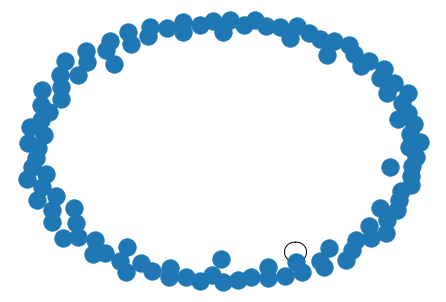

In [29]:
nx.algorithms.link_analysis.pagerank_alg.pagerank(G)

In [12]:
def train(model, data, train_idx, optimizer, loss_fn):
    # TODO: Implement a function that trains the model by 
    # using the given optimizer and loss_fn.
    model.train()
    loss = 0
    

    ############# Your code here ############
    ## Note:
    ## 1. Zero grad the optimizer
    optimizer.zero_grad()
    ## 2. Feed the data into the model
    out = model(data.x, data.adj_t)
    ## 3., 4. Slice the model output and label by train_idx & feed them to loss
    loss = loss_fn(out[train_idx], data.y[train_idx][:,0])
    #########################################

    loss.backward()
    optimizer.step()

    return loss.item()

In [13]:
data = 

model = weighted_GCN(1, args['hidden_dim'],
              dataset.num_classes, args['num_layers'],
              args['dropout']).to(device)

NameError: name 'GCN' is not defined